In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

### Convert gml to edgelist.csv. Optional.

In [2]:
def gml_to_edgelist(f):
    g = nx.read_gml(f)
    nx.write_edgelist(g, 'power.csv', delimiter=',')


In [3]:
def load_data(path):
    g = nx.read_edgelist(path, delimiter=',')
    return g

def generate_non_edge_list(g):
    n = len(g.edges()) # Negative edge list size is same as positive list size
    non_edges = []
    for u in g.nodes():
        for v in g.nodes():
            if u == v: continue
            if g.has_edge(u, v): continue
            non_edges.append((u, v))
    neg_sample = random.sample(non_edges, n)
    return neg_sample

def generate_class_labels(g, edges):
    y = []
    for edge in edges:
        if g.has_edge(edge[0], edge[1]):
            y.append(1)
        else:
            y.append(0)
    return y

### Implement features

In [4]:
def adamic_adar(g, X):
    preds = nx.adamic_adar_index(g, X)
    lst = []
    for u, v, p in preds:
        lst.append(p)

    max_p = max(lst)
    return [x/max_p for x in lst]

def jaccard(g, X):
    preds = nx.jaccard_coefficient(g, X)
    lst = []
    for u, v, p in preds:
        lst.append(p)

    max_p = max(lst)
    return [x/max_p for x in lst]

def common_neighbors(g, X):
    lst = []
    for x in X:
        cn = nx.common_neighbors(g, x[0], x[1])
        lst.append(len(list(cn)))
    max_p = float(max(lst))

    return [x/max_p for x in lst]

#### Jaccard

It's a simple measure of common features between two entities (in this case common neighbours). Jaccard coef is high if there are more similar features between 2 entiteis.

score(a, b) = p(a) n p (b) / p(a) u p (b)

#### Adamic Adar

This is a refinement jaccard coef. Rarer features are weighted heavily. If there is a common neighbour shared between two nodes which is rarely shared by any other node pairs. Then the score of this pair of nodes is high.

### Plot Curves

In [5]:
def plot_roc(fpt, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


### Load data

In [6]:
g = load_data('karate.csv')

### List of positive edges

In [7]:
EDGES_POSITIVE = list(g.edges())

### List of negative edges

In [8]:
EDGES_NEGATIVE = generate_non_edge_list(g)

In [9]:
EDGES = EDGES_POSITIVE + EDGES_NEGATIVE
random.shuffle(EDGES)

Y = generate_class_labels(g, EDGES)

feature1 = adamic_adar(g, EDGES)
feature2 = jaccard(g, EDGES)
feature3 = common_neighbors(g, EDGES)

data = [feature1, feature2, feature3, Y]

df = pd.DataFrame(data).transpose()
df.columns = ["Adamic_adar", "Jaccard", "Common neighbor", "Label"]

feature_values = df[["Adamic_adar", "Jaccard", "Common neighbor"]]

In [10]:
print ("Total nodes", len(g.nodes()))
print ("Total edges", len(g.edges()))
# print (df)

Total nodes 34
Total edges 78


## Training

### Multilayer perceptron

In [11]:
clf = MLPClassifier()


In [12]:
random_search = RandomizedSearchCV(clf, param_distributions={
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'alpha': [1e-2, 1e-3, 1e-4, 1e-5],
    'hidden_layer_sizes': scipy.stats.randint(4, 12),
    'solver': ['lbfgs', 'sgd', 'adam'],
    'early_stopping': [True, False],
    'activation': ["relu", "logistic", "tanh"]})

random_search.fit(feature_values, Y)

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-pack

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': ['constant', 'invscaling', 'adaptive'], 'alpha': [0.01, 0.001, 0.0001, 1e-05], 'hidden_layer_sizes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe9c06be320>, 'solver': ['lbfgs', 'sgd', 'adam'], 'early_stopping': [True, False], 'activation': ['relu', 'logistic', 'tanh']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', 

### Learning Rate
* How much the current situation affect the next step
* Step size


### Momentum
* How much past steps affect the next step
* Used to prevent converging at a local minimum

### Nesterov momentum
* Performs slightly better than regular momentum
* Momentum is calculated for the "lookahead" gradient step instead of the current stale position
http://cs231n.github.io/neural-networks-3/#sgd

### Early Stopping

A technique for controlling overfitting in machine learning models, especially neural networks, by stopping training before the weights have converged. Often the training is stopped when performance has stopped improving on a held-out validation set

### Activation Functions

#### Sigmoid

* Tends to vanish gradient
* Not good for deep learning
* Range: [0, 1]

#### Tanh
* Has stronger gradients than sigmoid
* Range: [-1, 1]

#### Relu

* Reduces the likelihood of vanishing gradient
* Less calculation load
* Sparse (percentage of neurons that are active at the same time are very low)
* Range: [0, inf]

In [13]:
### Validation

In [14]:
pred_proba = cross_val_predict(random_search, feature_values, Y, cv=6, method='predict_proba')
pred = cross_val_predict(random_search, feature_values, Y, cv=6)

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-pack

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/lib/python3.6/site-pack

In [15]:
print ("Accuracy:", accuracy_score(df[["Label"]], pred))
precision, recall, fscore, support = precision_recall_fscore_support(df[["Label"]], pred, average='binary')
print ("Precision:", precision)
print ("Recall:", recall)
print ("f-score:", fscore)

Accuracy: 0.762820512821
Precision: 0.805970149254
Recall: 0.692307692308
f-score: 0.744827586207


### ROC Curve

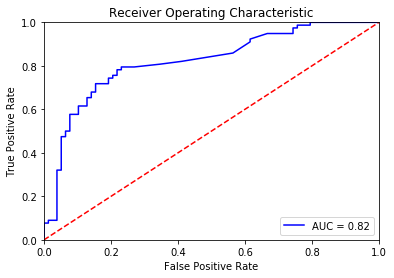

In [16]:
fpr, tpr, threshold = roc_curve(df[["Label"]], pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

### SVM

In [17]:
clf = svm.SVC(probability=True)
random_search = RandomizedSearchCV(clf, param_distributions={
    'kernel': ["rbf"],
    'gamma': np.logspace(-9, 3, 13),
    'C': np.logspace(-2, 10, 13)})
random_search.fit(feature_values, Y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'kernel': ['rbf'], 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'C': array([  1.00000e-02,...0000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [18]:
pred = cross_val_predict(random_search, feature_values, Y, cv=6)
pred_proba = cross_val_predict(random_search, feature_values, Y, cv=6, method='predict_proba')

In [19]:
print ("Accuracy:", accuracy_score(Y, pred))
precision, recall, fscore, support = precision_recall_fscore_support(Y, pred, average='binary')
print ("Precision:", precision)
print ("Recall:", recall)
print ("f-score:", fscore)

Accuracy: 0.762820512821
Precision: 0.797101449275
Recall: 0.705128205128
f-score: 0.748299319728


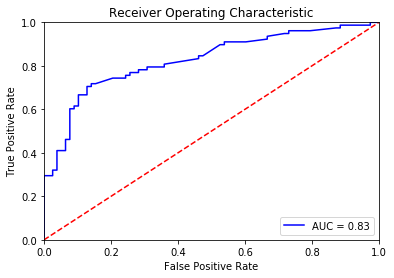

In [20]:
fpr, tpr, threshold = roc_curve(df[["Label"]], pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

### Random Forest

In [21]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)


In [22]:
param_dist = {"max_depth": [3, None],
              "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
print (param_dist)
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
random_search.fit(feature_values, Y)

{'max_depth': [3, None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': [3, None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [24]:
pred = cross_val_predict(random_search, feature_values, Y, cv=6)
pred_proba = cross_val_predict(random_search, feature_values, Y, cv=6, method='predict_proba')

In [25]:
print ("Accuracy:", accuracy_score(Y, pred))
precision, recall, fscore, support = precision_recall_fscore_support(Y, pred, average='binary')
print ("Precision:", precision)
print ("Recall:", recall)
print ("f-score:", fscore)

Accuracy: 0.724358974359
Precision: 0.746478873239
Recall: 0.679487179487
f-score: 0.711409395973


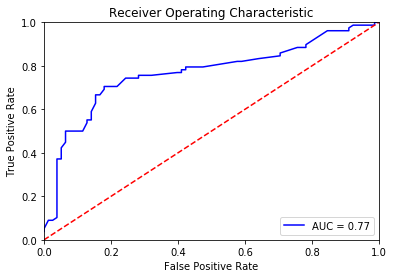

In [26]:
fpr, tpr, threshold = roc_curve(df[["Label"]], pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)